# Validate the pretrained model
For the same substructure, the contextSub pretrained model should generate similar embeddings when the local environments are similar while different embeddings when the environments are different.

In [1]:
import json

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import DrawingOptions
from torch_geometric.data import Batch
from torch_geometric.nn import global_mean_pool
import torch
from sklearn.manifold import TSNE
from sklearn import decomposition
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import numpy as np
import seaborn as sns
import umap

from contextSub.util import mol_to_graph_data_obj_simple
from contextSub.model import GNN
from contextSub.util import evaluate_pretraining, plot_embedding

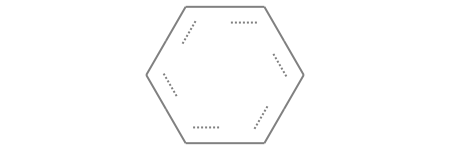

In [4]:
pattern = Chem.MolFromSmarts("c1ccccc1")
pattern

## Chemicals classified based on electron affinities

In [4]:
chm = "contextSub/dataset/testing_chemicals_surroundings.json"
pattern_embs, y = evaluate_pretraining(pattern, chm, "contextSub/trained_models/contextSub_chembl_2.pth")

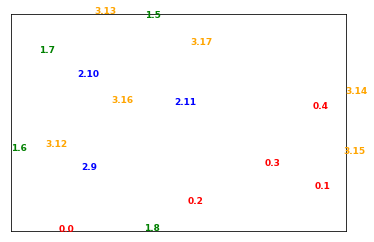

In [5]:
umap_emb = umap.UMAP(n_epochs=1000).fit_transform(pattern_embs)
plot_embedding(umap_emb, y, mode="text")

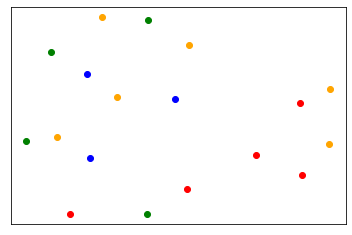

In [6]:
plot_embedding(umap_emb, y, mode="dot")

## Chemicals classified based on surround atom types

In [196]:
candidates_2 = json.load(open("contextSub/dataset/testing_chemicals_surroundings.json"))

### Prepare data and init model

In [197]:
data_list_2 = list()
for atom, sms in candidates_2.items():
    for sm in sms:
        mol = Chem.MolFromSmiles(sm)
        data = mol_to_graph_data_obj_simple(mol)
        data.atom = str(atom)
        data_list_2.append(data)
        data.substructs = torch.tensor(mol.GetSubstructMatch(pattern), dtype=torch.int)

In [198]:
batch = Batch.from_data_list(data_list_2)
batch

Batch(atom=[18], batch=[149], edge_attr=[298, 2], edge_index=[2, 298], substructs=[108], x=[149, 2])

In [199]:
model_substruct = GNN(
        5,
        300,
        JK="last",
        drop_ratio=0.5,
        gnn_type="gin",
    )
weights = torch.load("contextSub/trained_models/contextSub_chembl_2.pth")
model_substruct.load_state_dict(weights)
_ = model_substruct.eval()

### Get atom embeddings

In [200]:
embeddings = model_substruct(batch)

In [201]:
slices = list()
n = 0
while n < batch.batch.size(0):
    start = n
    curr_value = batch.batch[n].item()
    while n < batch.batch.size(0) and batch.batch[n].item() == curr_value:
        n += 1
    slices.append(slice(start, n))

In [202]:
molecule_embs = [embeddings[sl] for sl in slices]

In [203]:
ph_embs = list()
for data, emb in zip(data_list_2, molecule_embs):
    ph_embs.append(torch.mean(emb[data.substructs.to(torch.long)], 0).detach().numpy())

In [204]:
# y = [0] * 5 + [1] * 4 + [2] * 6 + [3] * 6
y = [0] * 5 + [1] * 4 + [2] * 3 + [3] * 6

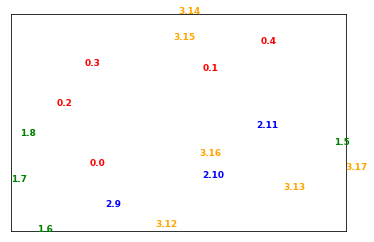

In [205]:
umap_emb = umap.UMAP(n_epochs=300).fit_transform(ph_embs)
plot_embedding(umap_emb)

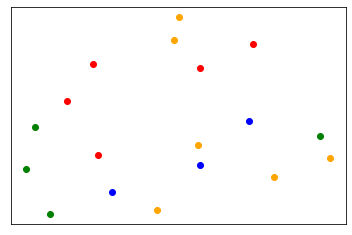

In [206]:
plot_embedding(umap_emb, mode="dot")

<AxesSubplot:>

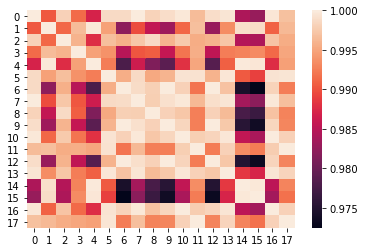

In [143]:
sns.heatmap(cosine_similarity(ph_embs, ph_embs))

## Structure frame based cluster

In [146]:
candidates_3 = json.load(open("contextSub/dataset/testing_chemicals_frame_based.json"))
data_list_3 = list()
for fm, sms in candidates_3.items():
    for sm in sms:
        mol = Chem.MolFromSmiles(sm)
        data = mol_to_graph_data_obj_simple(mol)
        data.frame = str(fm)
        data_list_3.append(data)
        data.substructs = torch.tensor(mol.GetSubstructMatch(pattern), dtype=torch.int)

In [147]:
batch = Batch.from_data_list(data_list_3)
batch

Batch(batch=[237], edge_attr=[474, 2], edge_index=[2, 474], frame=[29], substructs=[174], x=[237, 2])

In [148]:
model_substruct = GNN(
        5,
        300,
        JK="last",
        drop_ratio=0.5,
        gnn_type="gin",
    )
weights = torch.load("contextSub/trained_models/contextSub_chembl_2.pth")
model_substruct.load_state_dict(weights)
_ = model_substruct.eval()

In [150]:
embeddings = model_substruct(batch)
slices = list()
n = 0
while n < batch.batch.size(0):
    start = n
    curr_value = batch.batch[n].item()
    while n < batch.batch.size(0) and batch.batch[n].item() == curr_value:
        n += 1
    slices.append(slice(start, n))
molecule_embs = [embeddings[sl] for sl in slices]
ph_embs = list()
for data, emb in zip(data_list_3, molecule_embs):
    ph_embs.append(torch.mean(emb[data.substructs.to(torch.long)], 0).detach().numpy())

In [151]:
y = [0] * 1 + [1] * 7 + [2] * 7 + [3] * 7 + [4] * 7

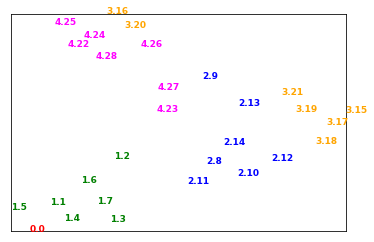

In [157]:
umap_emb = umap.UMAP(n_epochs=1000).fit_transform(ph_embs)
plot_embedding(umap_emb, mode="text")

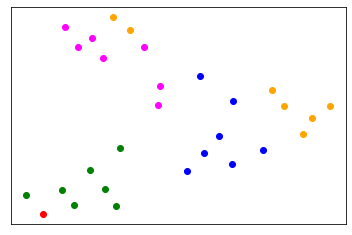

In [158]:
plot_embedding(umap_emb, mode="dot")

<AxesSubplot:>

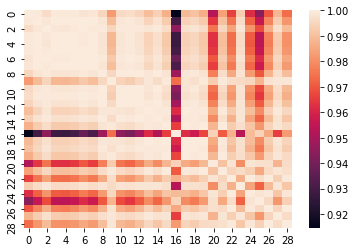

In [153]:
sns.heatmap(cosine_similarity(ph_embs, ph_embs))

In [173]:
candidates = json.load(open("contextSub/dataset/testing_chemicals_frame_based.json"))
data_list = list()
for fm, sms in candidates.items():
    for sm in sms:
        mol = Chem.MolFromSmiles(sm)
        data = mol_to_graph_data_obj_simple(mol)
        data.frame = str(fm)
        data_list.append(data)
        data.substructs = torch.tensor(mol.GetSubstructMatch(pattern), dtype=torch.int)

batch = Batch.from_data_list(data_list)
batch

Batch(batch=[237], edge_attr=[474, 2], edge_index=[2, 474], frame=[29], substructs=[174], x=[237, 2])

In [171]:
model_substruct = GNN(
        5,
        300,
        JK="last",
        drop_ratio=0.5,
        gnn_type="gin",
    )
weights = torch.load("contextSub/trained_models/contextpred.pth")
model_substruct.load_state_dict(weights)
_ = model_substruct.eval()

embeddings = model_substruct(batch)
slices = list()
n = 0
while n < batch.batch.size(0):
    start = n
    curr_value = batch.batch[n].item()
    while n < batch.batch.size(0) and batch.batch[n].item() == curr_value:
        n += 1
    slices.append(slice(start, n))
molecule_embs = [embeddings[sl] for sl in slices]
ph_embs = list()
for data, emb in zip(data_list, molecule_embs):
    ph_embs.append(torch.mean(emb[data.substructs.to(torch.long)], 0).detach().numpy())

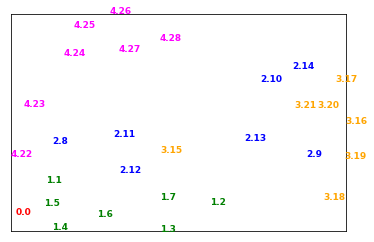

In [175]:
y = [0] * 1 + [1] * 7 + [2] * 7 + [3] * 7 + [4] * 7
umap_emb = umap.UMAP(n_epochs=1000).fit_transform(ph_embs)
plot_embedding(umap_emb, mode="text")

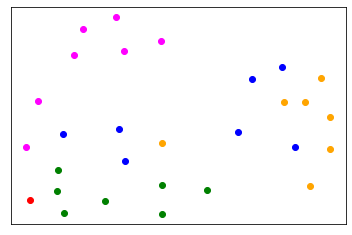

In [176]:
plot_embedding(umap_emb, mode="dot")

In [179]:
candidates = json.load(open("contextSub/dataset/testing_chemicals.json"))
data_list = list()
for feat in candidates.keys():
    for lv, sms in candidates[feat].items():
        for sm in sms:
            mol = Chem.MolFromSmiles(sm)
            data = mol_to_graph_data_obj_simple(mol)
            data.feat = str(feat)
            data.level = str(lv)
            data_list.append(data)
            data.substructs = torch.tensor(mol.GetSubstructMatch(pattern), dtype=torch.int)

batch = Batch.from_data_list(data_list)
batch

Batch(batch=[245], edge_attr=[492, 2], edge_index=[2, 492], feat=[28], level=[28], substructs=[168], x=[245, 2])

In [180]:
model_substruct = GNN(
        5,
        300,
        JK="last",
        drop_ratio=0.5,
        gnn_type="gin",
    )
weights = torch.load("contextSub/trained_models/contextpred.pth")
model_substruct.load_state_dict(weights)
_ = model_substruct.eval()

embeddings = model_substruct(batch)
slices = list()
n = 0
while n < batch.batch.size(0):
    start = n
    curr_value = batch.batch[n].item()
    while n < batch.batch.size(0) and batch.batch[n].item() == curr_value:
        n += 1
    slices.append(slice(start, n))
molecule_embs = [embeddings[sl] for sl in slices]
ph_embs = list()
for data, emb in zip(data_list, molecule_embs):
    ph_embs.append(torch.mean(emb[data.substructs.to(torch.long)], 0).detach().numpy())

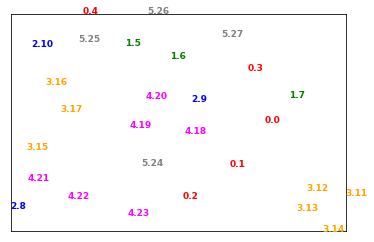

In [181]:
y = [0] * 5 + [1] * 3 + [2] * 3 + [3] * 7 + [4] * 6 + [5] * 4
umap_emb = umap.UMAP(n_epochs=1000).fit_transform(ph_embs)
plot_embedding(umap_emb, mode="text")

### ContextPred model

In [16]:
chm = "contextSub/dataset/testing_chemicals.json"
pattern_embs, y = evaluate_pretraining(pattern, chm, "contextSub/trained_models/contextpred.pth", partial_charge=False)

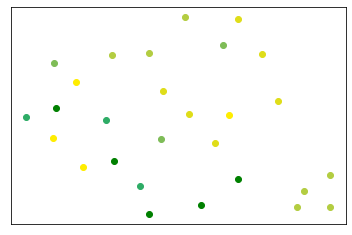

In [17]:
umap_emb = umap.UMAP(n_epochs=1000).fit_transform(pattern_embs)
colors = ["green", "#2eac66", "#7ebc57", "#b3cd41", "#dfdd19", "#ffed00"]
plot_embedding(umap_emb, y, mode="dot", cmap=colors)

### ContextSub model without partial charge property

In [14]:
chm = "contextSub/dataset/testing_chemicals.json"
pattern_embs, y = evaluate_pretraining(pattern, chm, "contextSub/trained_models/contextSub_chembl_2.pth", partial_charge=False)

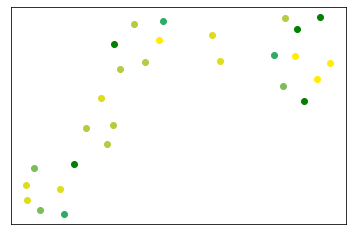

In [15]:
umap_emb = umap.UMAP(n_epochs=1000).fit_transform(pattern_embs)
colors = ["green", "#2eac66", "#7ebc57", "#b3cd41", "#dfdd19", "#ffed00"]
plot_embedding(umap_emb, y, mode="dot", cmap=colors)

### Partial charge pretrained model

In [27]:
chm = "contextSub/dataset/testing_chemicals_frame_based.json"
pattern_embs, y = evaluate_pretraining(pattern, chm, "contextSub/trained_models/contextSub_chembl_partialCharge.pth", partial_charge=True)

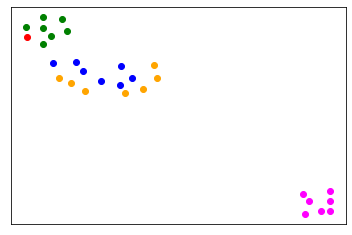

In [43]:
umap_emb = umap.UMAP(n_epochs=1000).fit_transform(pattern_embs)
plot_embedding(umap_emb, y, mode="dot")

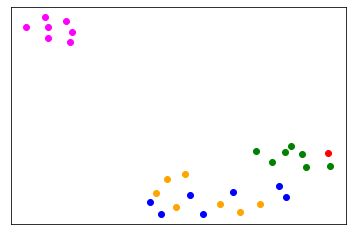

In [33]:
plot_embedding(umap_emb, y, mode="dot")

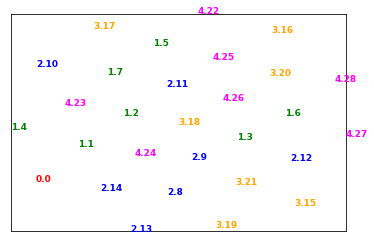

In [30]:
tsne_emb = TSNE(n_components=2, n_iter=1000).fit_transform(pattern_embs)
plot_embedding(tsne_emb, y, mode="text")

In [6]:
chm = "contextSub/dataset/testing_chemicals.json"
pattern_embs, y = evaluate_pretraining(pattern, chm, "contextSub/trained_models/contextSub_chembl_partialCharge.pth", partial_charge=True)

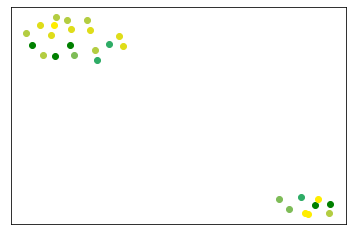

In [12]:
umap_emb = umap.UMAP(n_epochs=1000).fit_transform(pattern_embs)
colors = ["green", "#2eac66", "#7ebc57", "#b3cd41", "#dfdd19", "#ffed00"]
plot_embedding(umap_emb, y, mode="dot", cmap=colors)

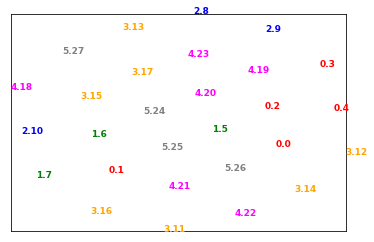

In [26]:
tsne_emb = TSNE(n_components=2, n_iter=1000).fit_transform(pattern_embs)
plot_embedding(tsne_emb, y, mode="text")

In [15]:
chm = "contextSub/dataset/testing_chemicals_surroundings.json"
pattern_embs, y = evaluate_pretraining(pattern, chm, "contextSub/trained_models/contextSub_chembl_partialCharge.pth", partial_charge=True)

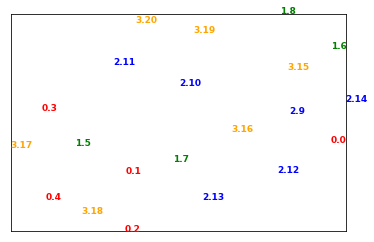

In [20]:
umap_emb = umap.UMAP(n_epochs=1000).fit_transform(pattern_embs)
plot_embedding(umap_emb, y, mode="text")

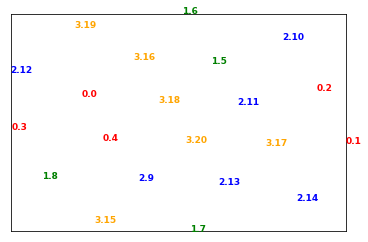

In [22]:
tsne_emb = TSNE(n_components=2, n_iter=500).fit_transform(pattern_embs)
plot_embedding(tsne_emb, y, mode="text")